# Importação de bibliotecas

In [1]:
# Para manipulção dos dados
import pandas as pd
import numpy as np
import math
import random as python_random
import time

# Visualização dos dados
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set_theme()

# Pré-processamento dos dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Criação de modelos

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
import tensorflow as tf

# # Métricas de avaliação
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, mean_squared_log_error


In [2]:
train = pd.read_csv('https://github.com/fellypesb/projeto_PET_2021/raw/main/Dados/local_BR/train_local_BR.csv')
valid = pd.read_csv('https://github.com/fellypesb/projeto_PET_2021/raw/main/Dados/local_BR/valid_local_BR.csv')

In [3]:
# Traduzindo as colunas

train = train.rename(columns={'month':'mes', 'day':'dia', 'hour':'hora', 'ghi':'irradiancia',\
                              'solar_zenith_angle':'angulo_zenite', 'clearsky_ghi':'irradiancia_ceu_claro',\
                              'relative_humidity':'umidade_relativa', 'temperature':'temperatura'})

valid = valid.rename(columns={'month':'mes', 'day':'dia', 'hour':'hora', 'ghi':'irradiancia',\
                              'solar_zenith_angle':'angulo_zenite', 'clearsky_ghi':'irradiancia_ceu_claro',\
                              'relative_humidity':'umidade_relativa', 'temperature':'temperatura'})

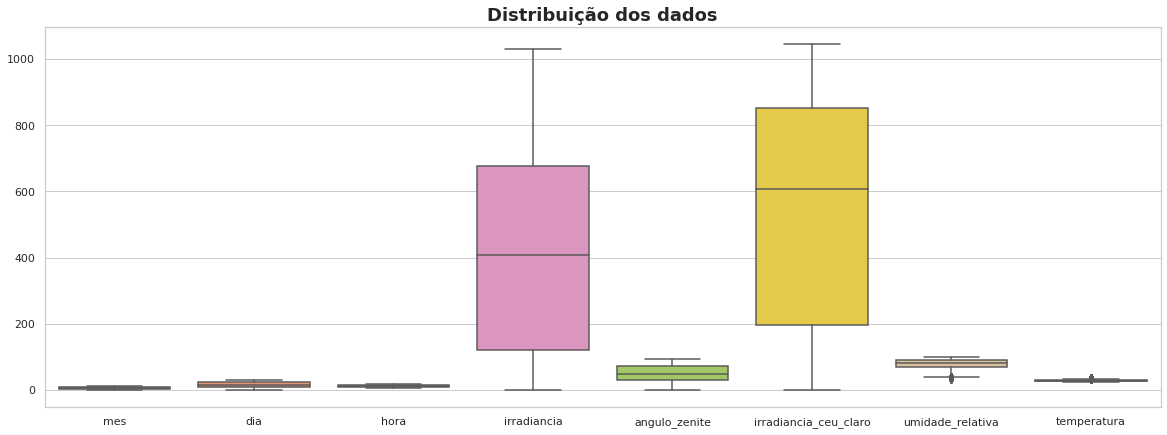

In [4]:
# boxplot de todos os atributos 

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(figsize=(20,7))
    sns.boxplot(data=train, palette='Set2')
    ax.set_title('Distribuição dos dados', fontdict={'fontsize':18, 'fontweight': 'bold'})
    plt.show()

Com o **boxplot** anterior, foi possível observar uma grande **discrepância** na distribuição dos dados. Com destaque para as variáveis de irrâdiancia solar e irrâdiancia solar de céu claro que apresentam as maiores variações, devido a possibilidade do resgistro de diferentes taxas de irradiância solar durante o dia. Essa discrepância na distribuição dos dados, pode ser **prejudicial** para o treinamento dos modelos, uma vez que, diferentes pesos de importância podem ser atribuídos aos atributos. Para solucionar este problema foi necessário a **normalização/escalonamento** dos atributos.  

### todo
+ Mudar título
+ Adicionar labels
+ Entender o que seria gráfico distorcido
+ Entender possíveis outlinears

In [5]:
# Calcula o horizonte de previsões

q_dias = valid.shape[0] / 13
q_meses = q_dias / 30
print(f'Horizonte de previsões aprox. {round(q_meses,2)} meses.')

Horizonte de previsões aprox. 1.09 meses.


# Divisão em atributos previsores e atributo alvo

In [6]:
X_train = train.drop('irradiancia', axis=1)
y_train = train['irradiancia']
X_valid = valid.drop('irradiancia', axis=1)
y_valid = valid['irradiancia']

# Escalonamento dos atributos

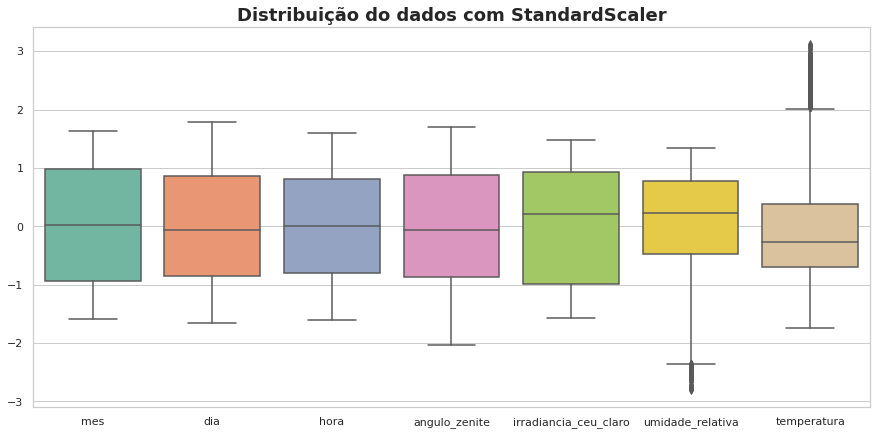

In [20]:
scaler = StandardScaler()

X_train_norm = scaler.fit_transform(X_train)
X_valid_norm = scaler.transform(X_valid)

y_train_norm = scaler.fit_transform(y_train.to_numpy().reshape(-1,1))
y_valid_norm = scaler.transform(y_valid.to_numpy().reshape(-1,1))

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(15,7))
    sns.boxplot(data=X_train_norm, palette='Set2')
    ax.set_title('Distribuição do dados com StandardScaler', fontdict={'fontsize':18, 'fontweight': 'bold'})
    plt.xticks([0,1,2,3,4,5,6], X_train.columns)
    plt.show()

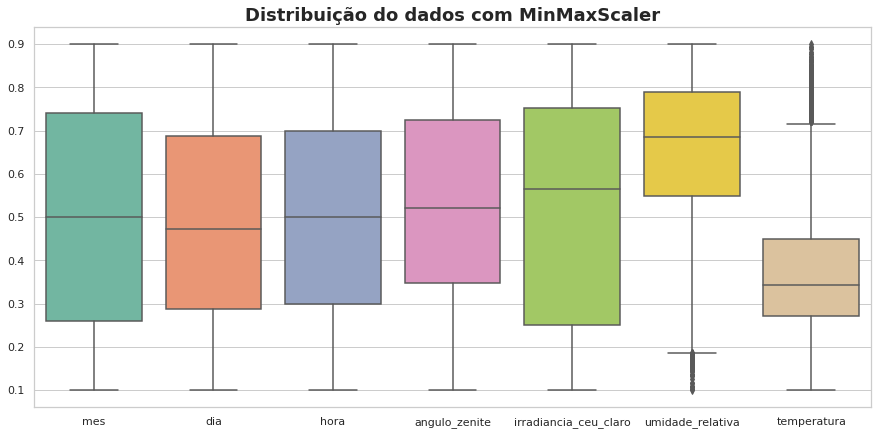

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0.1,0.9))

X_train_norm = scaler.fit_transform(X_train)
X_valid_norm = scaler.transform(X_valid)

y_train_norm = scaler.fit_transform(y_train.to_numpy().reshape(-1,1))
y_valid_norm = scaler.transform(y_valid.to_numpy().reshape(-1,1))

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(15,7))
    sns.boxplot(data=X_train_norm, palette='Set2')
    ax.set_title('Distribuição do dados com MinMaxScaler', fontdict={'fontsize':18, 'fontweight': 'bold'})
    plt.xticks([0,1,2,3,4,5,6], X_train.columns)
    plt.show()

# StandardScaler
# <center>$z = \frac{(x - \mu)}{\sigma}$</center>

Onde $x$ são as amostras do conjunto de dados, $\mu$ a média do astributo e $\sigma$, o desvio padrão.

A principal característica do StandardScaler e que após a normalização os dados passam a ter as seguintes propriedades estatísticas: 

+ Média = 0
+ Variância = 1

# MinMaxScaler
<center> $X = \frac{X - min(X)}{max(X) - min(X)}(max - min) + min$ </center>


# Propriedades estatísticas após normalização dos dados

In [ ]:
pd.DataFrame(X_train_norm).describe()

### todo
+ Verificar o makepipeline
+ ver artigo sobre a normalization

# Implementação da rede recorrente de ELMAN

### Aplicando a janela deslizante

In [11]:
def sliding_window(data, delay):
    '''
        Função que aplica a técnica de transformação dos dados em função de uma janela de tempo (lag)
    '''
    size_data = len(data)
    X, y = [], []
    for i in range(delay, size_data):
        X.append(data[i-delay:i])
        y.append(data[i])
    return np.asarray(X), np.asarray(y)

In [12]:
DELAY = 4
Xtrain, ytrain = sliding_window(y_train_norm, DELAY)
Xvalid, yvalid = sliding_window(y_valid_norm, DELAY)

In [13]:
# LAG = 13
# Xtrain, ytrain = sliding_window(treinamento[:,5], LAG)
# Xtest, ytest = sliding_window(teste[:,5], LAG)

In [14]:
# Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
# Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], 1))

# Xtrain.shape, Xtest.shape

###  Criação do modelo

In [15]:
SEED = 2021
np.random.seed(SEED)
tf.random.set_seed(SEED)
python_random.seed(SEED)

model = Sequential(name='Elman_RNN')

model.add(SimpleRNN(units=15,
                    input_shape=(Xtrain.shape[1], Xtrain.shape[2]),
                    activation='relu',
                    name='Recorrent_layer'))

model.add(Dense(units=1,
                activation='linear',
                name='output_layer'))

model.compile(optimizer=SGD(learning_rate=0.125, momentum=0.93),
             loss='mse',
             metrics=['mape'])

callback = EarlyStopping(monitor='loss', patience=10, min_delta=1e-8)
start = time.time()
hist = model.fit(Xtrain, ytrain, batch_size=64, epochs=100, callbacks=[callback], use_multiprocessing=True)
stop = time.time()

# Para obter os resultados de 10 execuções aleatórias
# Não esquecer de retirar o seed
# results = []
# for i in range(0,10):
#     print(f'---------- Execução {i+1}/10 ----------')
#     model.fit(Xtrain, ytrain, batch_size=32, epochs=100, callbacks=[callback], use_multiprocessing=True)
#     mse = model.evaluate(Xvalid, yvalid)[1]
#     results.append(math.sqrt(mse))

mape = model.evaluate(Xvalid, yvalid)[1]
print(f'MAPE: {mape}')
print('RunTime: {} seconds' .format(stop-start))

Epoch 1/100
67/67 [==============================] - 24s 3ms/step - loss: 0.0506 - mape: 65.5298
Epoch 2/100
67/67 [==============================] - 0s 3ms/step - loss: 0.0090 - mape: 23.7715
Epoch 3/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0069 - mape: 19.4353
Epoch 4/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0067 - mape: 18.9000
Epoch 5/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0064 - mape: 18.9228
Epoch 6/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0067 - mape: 19.0545
Epoch 7/100
67/67 [==============================] - 0s 3ms/step - loss: 0.0067 - mape: 18.7511
Epoch 8/100
67/67 [==============================] - 0s 3ms/step - loss: 0.0065 - mape: 18.1084
Epoch 9/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0065 - mape: 18.3730
Epoch 10/100
67/67 [==============================] - 0s 4ms/step - loss: 0.0068 - mape: 19.0865
Epoch 11/100
67/67 [==================

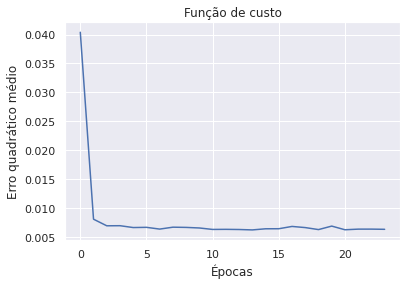

In [16]:
loss = hist.history['loss']
ax = sns.lineplot(data=loss, linewidth=1.5)
ax.set_title('Função de custo')
ax.set_xlabel('Épocas')
ax.set_ylabel('Erro quadrático médio')
plt.show()

In [17]:
ypred = model.predict(Xvalid)
yreal = yvalid

print(r2_score(yreal, ypred))
print(mean_squared_error(yreal, ypred, squared=False))

0.9228201891165537
0.06467262667935618


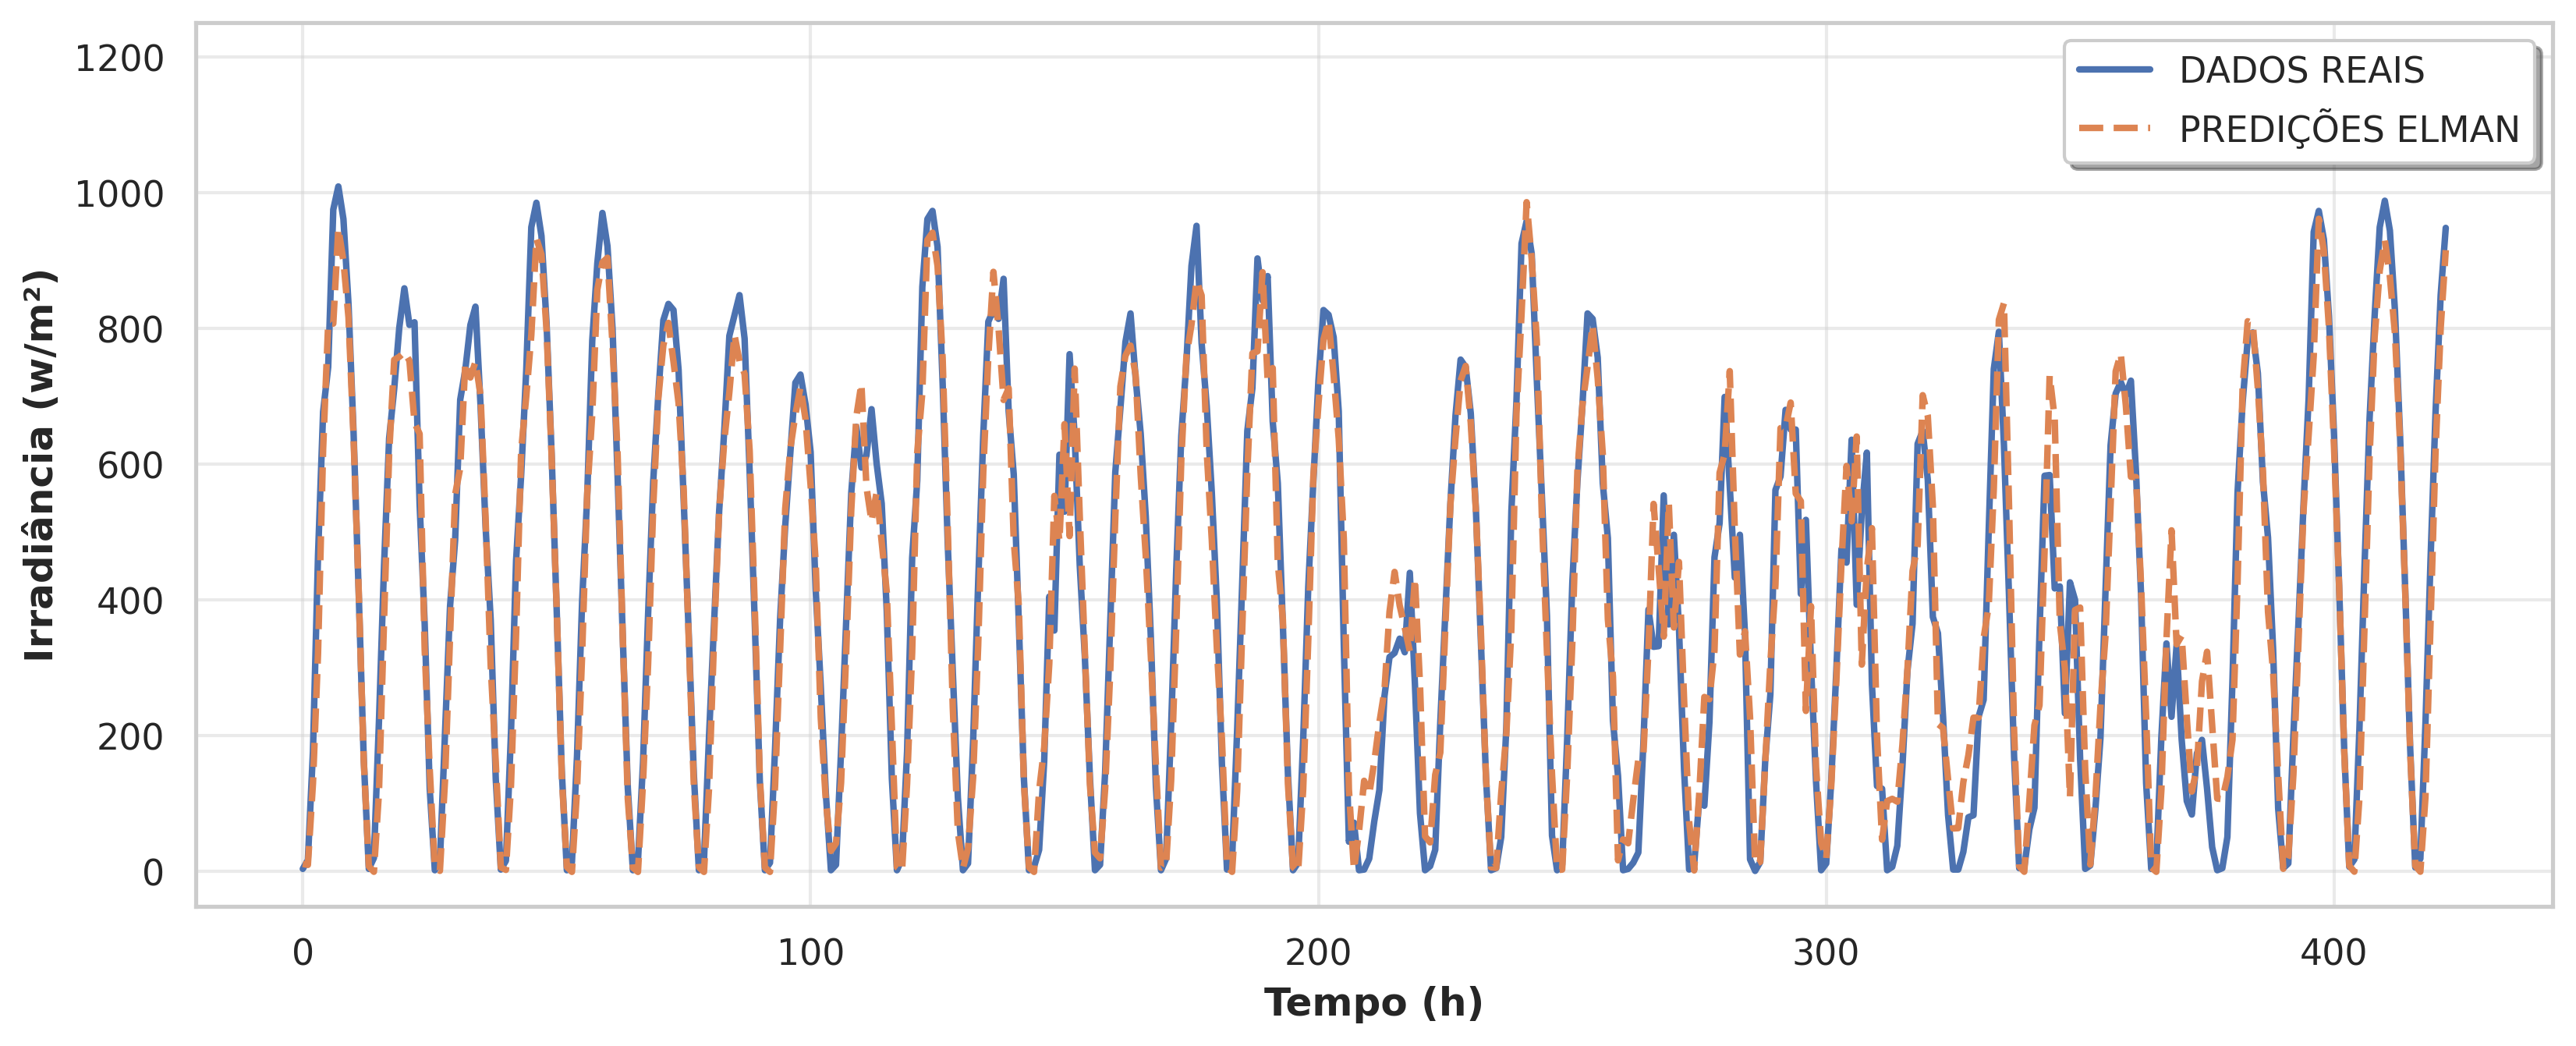

In [18]:
x1 = y_valid[4:].tolist()
x2 = model.predict(Xvalid)
x2 = scaler.inverse_transform(x2)

with sns.axes_style("whitegrid"):
    plt.figure(figsize=(13,5), dpi=300)
    #plt.title('Simple RNN', fontsize=12, weight='bold')
    plt.xlabel('Tempo (h)', fontsize=12, weight='bold')
    plt.ylabel('Irradiância (w/m²)', fontsize=12, weight='bold')
    plt.plot(x1,'-', label='DADOS REAIS', linewidth=2)
    plt.plot(x2,'--', label='PREDIÇÕES ELMAN', linewidth=2)
    plt.legend(loc='best', shadow=True)
    #plt.xlim(0, 10)
    plt.ylim(top=1250)
    plt.grid(alpha=0.4)
    #plt.savefig('../../Imagens/modelo_5.png', dpi=300)